# Affine transforms
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and clEsperanto

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

ImportError: cannot import name 'OCLProgram' from 'pyclesperanto_prototype._tier0._pycl' (c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier0\_pycl.py)

In [2]:
from skimage.io import imread, imshow
image = imread('../data/Haase_MRT_tfl3d1.tif')

(120, 160, 160)

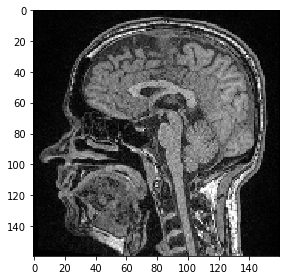

In [3]:
imshow(image[60])
image.shape

In [4]:
import numpy as np

# scaling by factor 1 / s
s = 0.5
matrix = np.asarray([
    [s, 0, 0, 0],
    [0, s, 0, 0],
    [0, 0, s, 0],
    [0, 0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) / s).astype(int))
print(output_shape)


(240, 320, 320)


## cupy

C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\cupyx\scipy\ndimage\interpolation.py:15: UserWarning: In the current feature the default order of affine_transform is 1. It is different from scipy.ndimage and can change in the future.
  warnings.warn('In the current feature the default order of {} is 1. '


cupy affine transform duration: 0.4258244037628174
cupy affine transform duration: 0.01000523567199707
cupy affine transform duration: 0.010988473892211914
cupy affine transform duration: 0.010972261428833008
cupy affine transform duration: 0.010921955108642578
cupy affine transform duration: 0.011012792587280273
cupy affine transform duration: 0.010975122451782227
cupy affine transform duration: 0.009923934936523438
cupy affine transform duration: 0.011012554168701172
cupy affine transform duration: 0.010970354080200195


C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


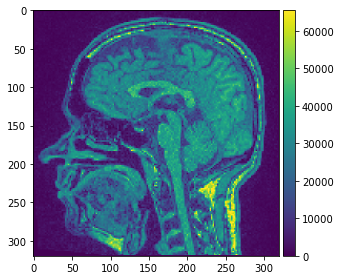

In [5]:
import time
import cupy
from cupyx.scipy import ndimage as ndi

cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
imshow(result[120])

## clEsperanto

clEsperanto affine transform duration: 0.03690147399902344
clEsperanto affine transform duration: 0.003954648971557617
clEsperanto affine transform duration: 0.0029942989349365234
clEsperanto affine transform duration: 0.00398564338684082
clEsperanto affine transform duration: 0.0030252933502197266
clEsperanto affine transform duration: 0.002960205078125
clEsperanto affine transform duration: 0.003988981246948242
clEsperanto affine transform duration: 0.003989696502685547
clEsperanto affine transform duration: 0.0030260086059570312
clEsperanto affine transform duration: 0.003954887390136719


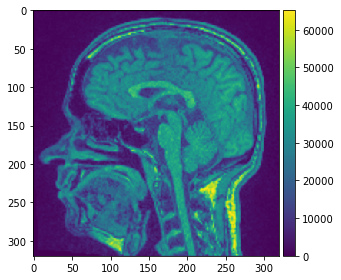

In [6]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result[120])

## Scipy

scipy affine transform duration: 9.005393266677856
scipy affine transform duration: 9.04822826385498
scipy affine transform duration: 9.089797019958496
scipy affine transform duration: 8.864994764328003
scipy affine transform duration: 9.063815832138062
scipy affine transform duration: 8.975829362869263
scipy affine transform duration: 8.582808256149292
scipy affine transform duration: 9.115242958068848
scipy affine transform duration: 9.170432567596436
scipy affine transform duration: 9.086284637451172


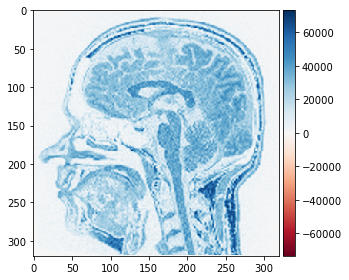

In [7]:
import time
from scipy import ndimage as sndi

scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

imshow(scaled[120])